### IMBH Forecast

TODO:
- obscured fraction
- dust extinction/reddening effects
- 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle
from taufit import simulate_from_psd, smoothly_broken_power_law, fit_drw

from tqdm.notebook import tqdm

import scipy.stats as st

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

In [2]:
from model import DemographicModel, ERDF, calc_sigma_var, lambda_obs

In [3]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [4]:
set_mpl_style()

No handles with labels found to put in legend.


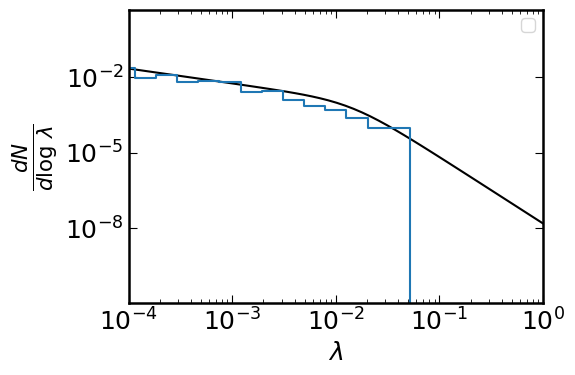

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

l = np.logspace(-7, 1, 100)
dlogl = np.diff(np.log10(l))[0]
p = ERDF(l)*dlogl
p = p/np.sum(p)
s = np.random.choice(l, 100000, p=p)

ax.loglog(l, p/dlogl, c='k')

bins = np.logspace(-7, 3, 50)
h, bin_edges = np.histogram(s, bins=bins)
ax.step(bin_edges[:-1], h/np.diff(np.log10(bins))[0]/len(s))

ax.set_xlabel(r'$\lambda$', fontsize=18)
ax.set_ylabel(r'$\frac{dN}{d\log\ \lambda}$', fontsize=22)

ax.legend(fontsize=12)

ax.tick_params('both', labelsize=18)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xlim(1e-4, 1e0)

fig.tight_layout()

### Load previous model instance

In [19]:
# May need to run one at a time to save memory
keys = ['ptf']

In [20]:
nbootstrap = 16
nbins = 20

# Assuming ~SDSS solid angle
omegas = {'ptf':14000*u.deg**2, 'lsst':18000*u.deg**2, 'des-sn':4.64*u.deg**2}
zmaxes = {'ptf':0.055, 'lsst':0.055, 'des-sn':1.5}
ndraws = {'ptf':4e9, 'lsst':4e9, 'des-sn':4e9}
etas = {'ptf':10, 'lsst':10, 'des-sn':10}

models = {}
for key in keys:
    models[key] = DemographicModel()
    omega_sr = omegas[key].to(u.sr).value
    models[key].sample(nbins=nbins, nbootstrap=nbootstrap, zmax=zmaxes[key], eta=etas[key],
                       ndraw_dim=ndraws[key]/etas[key], omega=omega_sr, ERDF_mode=0)
    #, seed_dict={'dc':(lambda x: np.ones_like(x))})
    

Using Reines et al. 2015 host-BH mass relation for low redshifts


  0%|          | 0/16 [00:00<?, ?it/s]

3067480
1660841
1594865
1555412
2148564
1139737
2134019
1679564
1722555
1736400
2243883
1381890
1317032
2276928
1593086
3405911


### Host galaxy colors and dilution

In [24]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
# Load NASA Sloan Atlas (DR13)
hdul_nsa = fits.open('/data3/nsa_v0_1_2.fits') ## OLD VERSION!
data_nsa = hdul_nsa[1].data

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in subtract
/home/colinjb2

[10.6067998   1.26228215 -0.21168494]
0.23525426


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in subtract
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


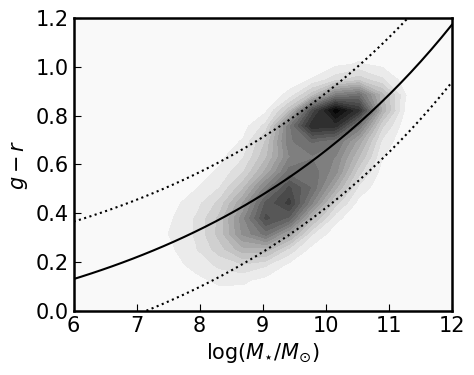

In [75]:
from scipy.optimize import curve_fit


g = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,3]) # g
r = 22.5 - 2.5*np.log10(data_nsa['PETROFLUX'][:,4]) # r
stellar_mass = data_nsa['MASS']


# Define the fitting function
def func(x, a, b, c):
    x = x-a
    return b**x + c

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

mask_na = np.isfinite(stellar_mass) & np.isfinite(g-r)

xx, yy = np.mgrid[5:12:20j, 0:1.2:20j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([np.log10(stellar_mass)[mask_na], (g-r)[mask_na]])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

cfset = ax.contourf(xx, yy, f, levels=20, cmap='binary')

#ax.scatter(np.log10(stellar_mass), g-r, s=0.001, color='gray')
ax.set_ylim([0.0, 1.2])
ax.set_xlim([6, 12])

#p = np.polyfit(np.log10(stellar_mass[mask_na])-10, (g-r)[mask_na], 2)
p, pcov = curve_fit(func, np.log10(stellar_mass[mask_na]), (g-r)[mask_na])
x = np.linspace(4, 12)
#ax.plot(x, np.polyval(p, x-10), color='k')
ax.plot(x, func(x, *p), color='k')

print(p)

#res = (g-r)[[mask_na]] - np.polyval(p, np.log10(stellar_mass[mask_na])-10)
res = (g-r)[[mask_na]] - func(np.log10(stellar_mass[mask_na]), *p)

rms = np.nanstd(res)
print(np.nanstd(res))

#ax.plot(x, np.polyval(p, x-10)-rms, color='k', linestyle='dotted')
#ax.plot(x, np.polyval(p, x-10)+rms, color='k', linestyle='dotted')
ax.plot(x, func(x, *p) - rms, color='k', linestyle='dotted')
ax.plot(x, func(x, *p) + rms, color='k', linestyle='dotted')

ax.set_ylabel(r'$g - r$')
ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')

fig.tight_layout()
fig.savefig('color.pdf', dpi=300)

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[-0.1182058   3.30438841  0.01309727]
0.3449262


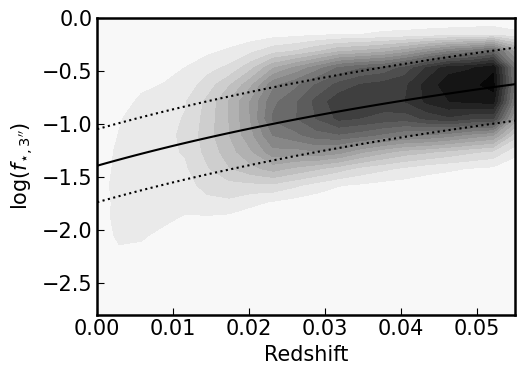

In [11]:
from scipy.optimize import curve_fit

f_host = data_nsa['FIBERFLUX'][:,3]/data_nsa['PETROFLUX'][:,3]

mask_na = np.isfinite(data_nsa['Z']) & (f_host<1) & (f_host>0) 

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

xx, yy = np.mgrid[0:0.055:20j, -3:0:20j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([data_nsa['Z'][mask_na], np.log10(f_host[mask_na])])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

cfset = ax.contourf(xx, yy, f, levels=20, cmap='binary')

#ax.scatter(data_nsa['Z'], np.log10(f_host), s=0.001, c='gray')
ax.set_ylim([-2.8, 0])
ax.set_xlim([0, 0.055])

# Define the fitting function
def func(x, a, b, c):
    x = x-a
    return 1 - 1/(x**2 + b*x + c)


#p = np.polyfit(data_nsa['Z'][mask_na], np.log10(f_host[mask_na]), 2)
p, pcov = curve_fit(func, data_nsa['Z'][mask_na], np.log10(f_host[mask_na]))
x = np.linspace(0, 0.06)
#ax.plot(x, np.polyval(p, x), color='k')
ax.plot(x, func(x, *p), color='k')


print(p)

#res = np.log10(f_host[mask_na]) - np.polyval(p, data_nsa['Z'][mask_na])
res = np.log10(f_host[mask_na]) - func(data_nsa['Z'][mask_na], *p)

rms = np.nanstd(res)
print(np.nanstd(res))

#ax.plot(x, np.polyval(p, x) - rms, color='k', linestyle='dotted')
#ax.plot(x, np.polyval(p, x) + rms, color='k', linestyle='dotted')
ax.plot(x, func(x, *p) - rms, color='k', linestyle='dotted')
ax.plot(x, func(x, *p) + rms, color='k', linestyle='dotted')

ax.set_ylabel(r'$\log(f_{\star, {\rm{3^{\prime\prime}}}})$')
ax.set_xlabel(r'Redshift')

fig.tight_layout()
fig.savefig('fhost.pdf', dpi=300)

### Plot model summary figure

In [12]:
pars = {}
for key in keys:
    pars[key] = models[key].pars

stellar_mass = data_nsa['MASS']
M_star_ = pars[keys[0]]['M_star_'].value
M_star = pars[keys[0]]['M_star'].value
n_i, _ = np.histogram(stellar_mass, bins=M_star_)
dlogM_star = np.diff(np.log10(M_star_))

print(len(stellar_mass[stellar_mass>0]))

omega = (14000*u.deg**2).to(u.sr) # DR8 https://www.sdss3.org/dr8/
V = cosmo.comoving_volume(0.055)*omega/(4*np.pi)
phi_i = n_i/V/dlogM_star

def phi_X(L_X):
    # https://iopscience.iop.org/article/10.1088/0004-637X/749/1/21/pdf
    
    A = 113.1*1e-7
    L_br = 0.51*1e44
    gamma1 = 0.79
    gamma2 = 2.39
    # z=0
    return A/(np.log(10)) * ((L_X/L_br)**gamma1 + (L_X/L_br)**gamma2)**-1 #1/L_X

145154


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/colinjb2/forecast/model.py:750: RuntimeWarning: Mean of empty slice
  axs[0].scatter(M_star, moct(n_i_M, axis=0)/dlogM_star/V, lw=3, color='k')
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/colinjb2/forecast/model.py:815: RuntimeWarning: Mean of empty slice
  norm = np.nansum(moct(n_i_Edd, axis=0)*dloglambda)
/home/colinjb2/forecast/model.py:816

NameError: name 'phi_i' is not defined

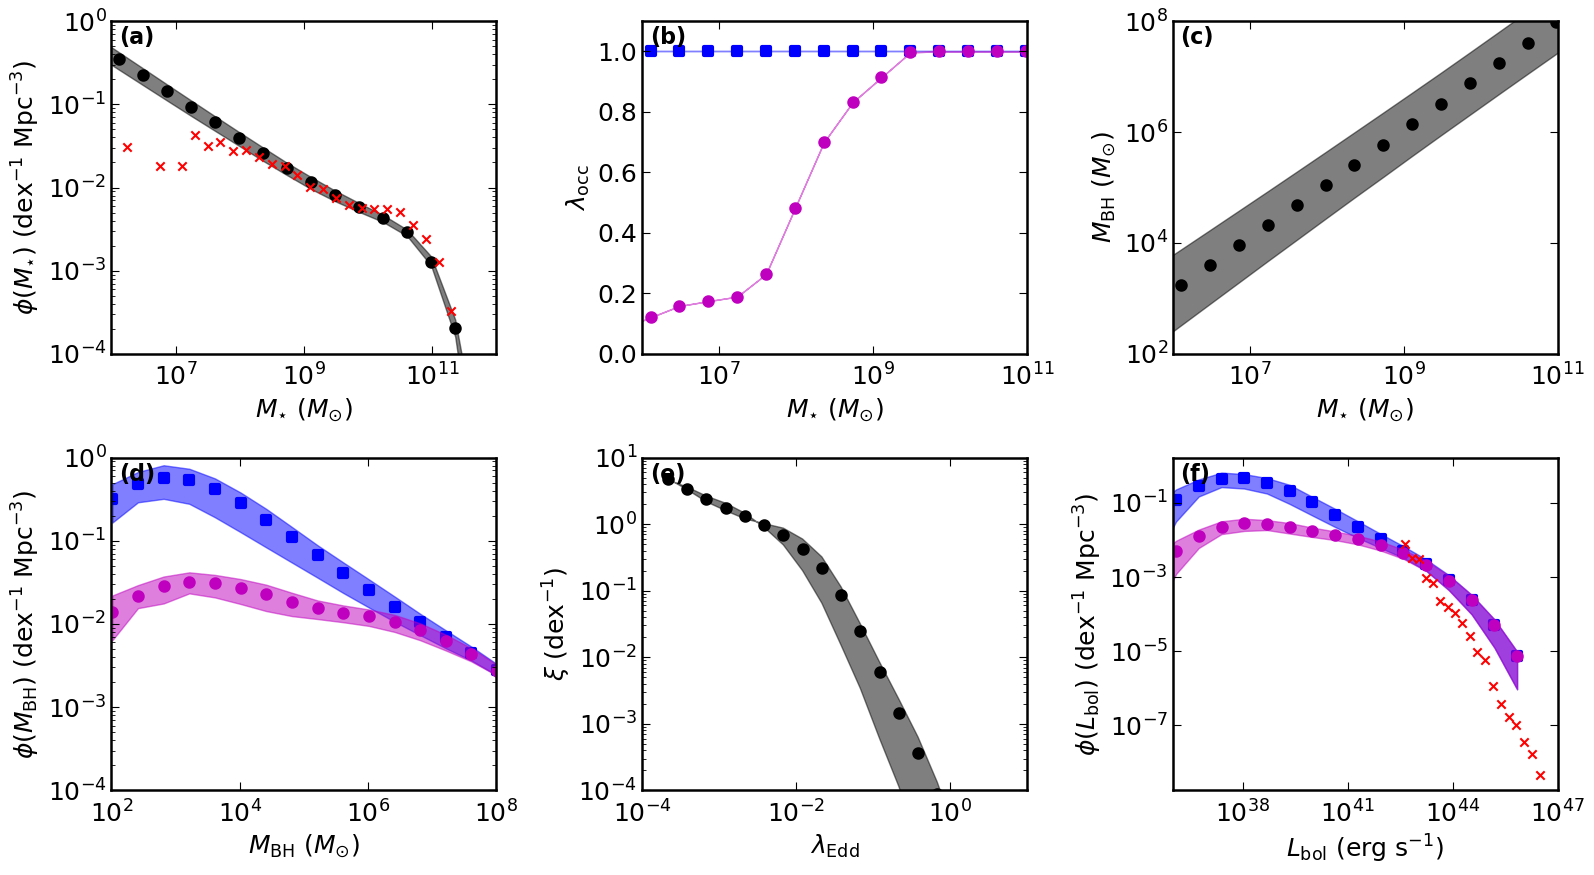

In [31]:
plot = True

if plot and etas[key] >= 10:

    fig_ptf = models[keys[0]].plot()
    #fig_lsst = model_lsst.plot()

    axs = fig_ptf.axes
    axs[0].scatter(M_star, phi_i, marker='o', facecolors='none', edgecolors='r')
    
    L_X = np.logspace(41, 46)
    dlogL_X = np.diff(np.log10(L_X))[0]
    axs[-1].plot(L_X/1e-1, phi_X(L_X)/dlogL_X, color='r')

    fig_ptf.savefig('model.pdf', dpi=300)

### Sample grid of SEDs

In [21]:
bands = {'ptf':'GROUND_COUSINS_R', 'lsst':'SDSS_g', 'des-sn':'SDSS_g'}

for key in keys:
    models[key].sample_sed_grid(band=bands[key])

Setting up model SED
Creating SED grid in band GROUND_COUSINS_R
Sampling SEDs with seeding mechanism dc


  0%|          | 0/16 [00:00<?, ?it/s]

/home/colinjb2/.local/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Sampling SEDs with seeding mechanism popIII


  0%|          | 0/16 [00:00<?, ?it/s]

### Mock Observations: light curves

PTF:

In [22]:
if 'ptf' in keys:

    num_seasons = 4 # years
    season_duration = 95 # days
    cadence = 5 #5 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['ptf'].sample_light_curves(t_obs, band=bands['ptf'], dt_min=cadence//2)

Sampling light curves with seeding mechanism dc


  0%|          | 0/16 [00:00<?, ?it/s]

Sampling light curves with seeding mechanism popIII


  0%|          | 0/16 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:260: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9) + np.random.normal(0, 0.09, size=len(M_BH))) # Delta mag
/home/colinjb2/forecast/model.py:268: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9)) # Delta mag
/home/colinjb2/forecast/model.py:280: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days


LSST:

In [17]:
if 'lsst' in keys:

    num_seasons = 10 # years
    season_duration = 95 # days
    cadence = 25 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['lsst'].sample_light_curves(t_obs, band=bands['lsst'], dt_min=cadence//2)

DES-SN

In [9]:
if 'des-sn' in keys:

    num_seasons = 6 # years
    season_duration = 95 # days
    cadence = 7 #5 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()

    models['des-sn'].sample_light_curves(t_obs, band=bands['des-sn'], dt_min=cadence//2)

Sampling light curves with seeding mechanism dc


  0%|          | 0/16 [00:00<?, ?it/s]

Sampling light curves with seeding mechanism popIII


  0%|          | 0/16 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:260: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9) + np.random.normal(0, 0.09, size=len(M_BH))) # Delta mag
/home/colinjb2/forecast/model.py:268: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e9)) # Delta mag
/home/colinjb2/forecast/model.py:280: RuntimeWarning: divide by zero encountered in log10
  D*np.log10(M_BH/1e8) + np.random.normal(0, 0.09, size=size)) # days


LSST hybrid

In [54]:
special = True

if 'lsst' in keys and special:

    # LSST Special
    num_seasons = 1
    season_duration = 5 # days
    cadence = 0.1 # days
    t_obs = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs = np.array(t_obs).flatten()
    
    num_seasons = 10
    season_duration = 95 # days
    cadence = 25 # days
    t_obs2 = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
    t_obs2 = np.array(t_obs2).flatten()
    
    t_obs = np.sort(np.concatenate([t_obs, t_obs2]))

    models['lsst'].sample_light_curves(t_obs, band=bands['lsst'],  dt_min=0.1/2)

In [23]:
pars = {}
samples = {}
for key in keys:
    pars[key] = models[key].pars
    samples[key] = models[key].samples

#np.save('s_lsst.npy', s_lsst)
#np.save('s_ptf.npy', s_ptf)

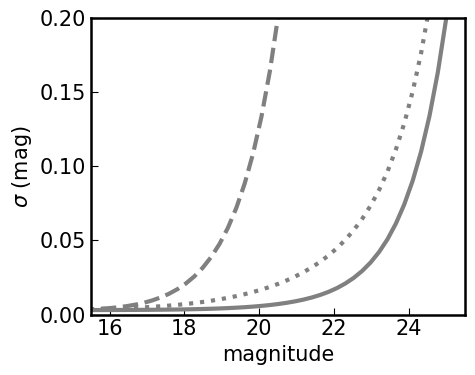

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

m_eval = np.linspace(14, 25)
m_5 = {'ptf':20.5, 'lsst':25.0, 'des-sn':24.5}
m_sat = {'ptf':14.0, 'lsst':16.0, 'des-sn':18}
gamma = {'ptf':0.04, 'lsst':0.038, 'des-sn':0.024}


def pm_prec(mag, gamma=0.038, m_5=25.0, sigma_sys=0.003):
    x = 10**(0.4*(mag - m_5))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*x**2)
    return np.sqrt(sigma_sys**2 + sigma_rand**2)

pm_prec_lsst = pm_prec(m_eval, gamma=gamma['lsst'], m_5=m_5['lsst'])
pm_prec_ptf = pm_prec(m_eval, gamma=gamma['ptf'], m_5=m_5['ptf'])
pm_prec_des = pm_prec(m_eval, gamma=gamma['des-sn'], m_5=m_5['des-sn'])


ax.plot(m_eval, pm_prec_lsst, color='gray', lw=3)
ax.plot(m_eval, pm_prec_ptf, color='gray', lw=3, linestyle='dashed')
ax.plot(m_eval, pm_prec_des, color='gray', lw=3, linestyle='dotted')


ax.set_xlim(15.5, 25.5)
ax.set_ylim(0, .2)
ax.set_ylabel(r'$\sigma$ (mag)')
ax.set_xlabel(r'magnitude')

fig.tight_layout()
fig.savefig('phprec.pdf', dpi=300)

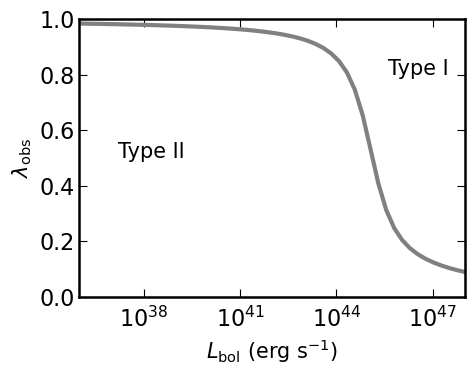

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

from model import lambda_obs

L_bol = np.logspace(36, 48)

ax.semilogx(L_bol, lambda_obs(L_bol, randomize=False), color='gray', lw=3)

ax.text(0.1, 0.5, 'Type II', transform=ax.transAxes)
ax.text(0.8, 0.8, 'Type I', transform=ax.transAxes)


ax.set_xlim(1e36, 1e48)
ax.set_ylim(0, 1)
ax.set_ylabel(r'$\lambda_{\rm{obs}}$')
ax.set_xlabel(r'$L_{\rm{bol}}$ (erg s$^{-1}$)')

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('obs.pdf', dpi=300)

### Variability analysis

In [26]:
import celerite
from celerite import terms
from scipy.optimize import minimize

def fit_drw(x, y, yerr):
    
    # Sort data
    ind = np.argsort(x)
    x = x[ind]; y = y[ind]; yerr = yerr[ind]
    baseline = x[-1]-x[0]
    
    min_precision = np.min(yerr.value)
    amplitude = np.max(y.value+yerr.value)-np.min(y.value-yerr.value)
    amin = np.log(0.001*min_precision)
    amax = np.log(10*amplitude)
    log_a = np.mean([amin,amax])

    min_cadence = np.clip(np.min(np.diff(x.value)), 1e-8, None)
    cmin = np.log(1/(10*baseline.value))
    cmax = np.log(1/min_cadence)
    log_c = np.mean([cmin,cmax])

    smin = -10
    smax = np.log(amplitude)
    log_s = np.mean([smin,smax])
    
    # Kernel
    kernel = terms.RealTerm(log_a=log_a, log_c=log_c,
                            bounds=dict(log_a=(amin, amax), log_c=(cmin, cmax)))
    
    # Add jitter term
    kernel += terms.JitterTerm(log_sigma=log_s, bounds=dict(log_sigma=(smin, smax)))
    
    # Find MLE
    gp = celerite.GP(kernel, mean=np.mean(y.value), fit_mean=True)
    gp.compute(x.value, yerr.value)

    # Define a cost function
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]

    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
        
    # MLE solution
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y.value, gp))
    initial = np.array(soln.x)
        
    return initial

In [27]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from qsofit import qso_fit
#from taufit import fit_drw

fit = False

for k, (key, s) in enumerate(samples.items()):
    
    print(key)
    
    band = bands[key]
    nbootstrap = pars[key]['nbootstrap']
    ndraw_dim = int(np.max(s['ndraws']))
    seed_keys = list(pars[key]['seed_dict'].keys())
    
    t_obs = s['lc_t_obs']

    for i, seed in enumerate(seed_keys):
        
        print(seed)

        s[f'sigma_var_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'std_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)
        s[f'tau_{seed}'] = np.full([nbootstrap, pars[key]['ndraw_dim']], np.nan)

        for j in tqdm(range(nbootstrap)): # 1
            ndraw = int(s['ndraws'][j])
            # Get magnitudes
            mag = s[f'lc_{band}_{seed}_{j}']
            # Get uncertainties from photometric precision model
            magerr = pm_prec(mag, gamma=gamma[key], m_5=m_5[key])
            # Calculate variability significance
            indx = s[f'lc_{band}_{seed}_idx'][j,:ndraw]
            indx = indx[np.isfinite(indx)].astype(np.int)
            # Add uncertainty
            mag_obs = np.random.normal(mag, magerr)
            s[f'sigma_var_{seed}'][j,indx] = calc_sigma_var(mag_obs, magerr)
            s[f'std_{seed}'][j,indx] = np.std(mag_obs, axis=1)
            
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw] > 2
            var_indx = np.where(mask_var)[0]
            
            taus = np.full(ndraw_dim, np.nan)
            if fit:
                for l, v in enumerate(indx):

                    if s[f'sigma_var_{seed}'][j,v] > 2:

                        initial = fit_drw(t_obs*u.day, mag_obs[l]*u.mag, magerr[l]*u.mag) # m here is wrong
                        s[f'tau_{seed}'][j,v] = 1/np.exp(initial[1])

ptf
dc


  0%|          | 0/16 [00:00<?, ?it/s]

/home/colinjb2/forecast/model.py:98: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)


popIII


  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
s.keys()

dict_keys(['zmax', 'zmin', 'M_star_draw', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'n_i_M_dc', 'M_BH_draw_popIII', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_dc', 'n_i_L_dc', 'L_draw_popIII', 'n_i_L_popIII', 'ndraws', 'L_GROUND_COUSINS_R_model', 'M_i_model', 'L_GROUND_COUSINS_R_dc', 'M_i_dc', 'L_GROUND_COUSINS_R_popIII', 'M_i_popIII', 'lc_t_obs', 'lc_GROUND_COUSINS_R_dc_idx', 'm_GROUND_COUSINS_R_dc', 'm_host_GROUND_COUSINS_R_dc', 'SFinf_GROUND_COUSINS_R_dc', 'tau_RF_GROUND_COUSINS_R_dc', 'L_host_GROUND_COUSINS_R_dc', 'lc_GROUND_COUSINS_R_dc_0', 'lc_GROUND_COUSINS_R_dc_1', 'lc_GROUND_COUSINS_R_dc_2', 'lc_GROUND_COUSINS_R_dc_3', 'lc_GROUND_COUSINS_R_dc_4', 'lc_GROUND_COUSINS_R_dc_5', 'lc_GROUND_COUSINS_R_dc_6', 'lc_GROUND_COUSINS_R_dc_7', 'lc_GROUND_COUSINS_R_dc_8', 'lc_GROUND_COUSINS_R_dc_9', 'lc_GROUND_COUSINS_R_dc_10', 'lc_GROUND_COUSINS_R_dc_11', 'lc_GROUND_COUSINS_R_dc_12', 'lc_GROUND_COUSINS_R_dc_13', 'lc_GROUND_COUSINS_R_dc_14', 'lc_GROUND_COUSINS_R_dc_15', 'lc_GROUN

In [ ]:
s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat]

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10


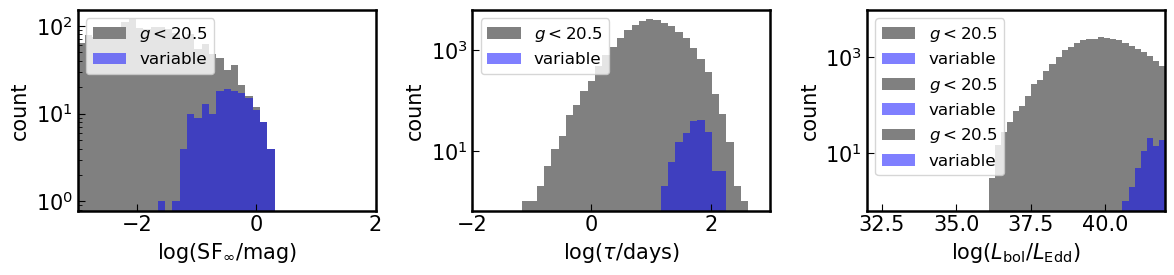

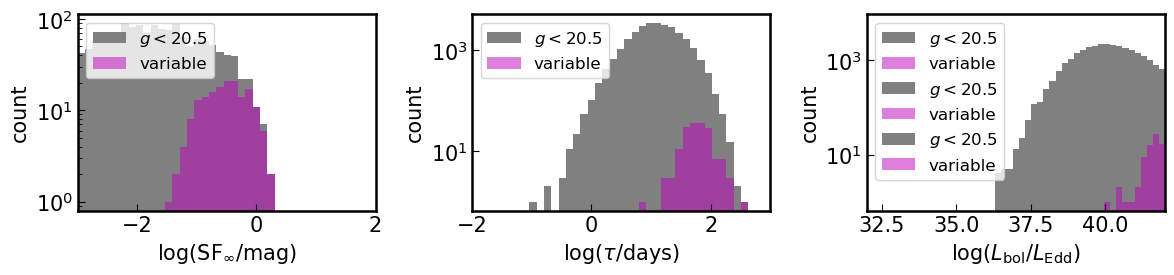

In [28]:
for k, (key, s) in enumerate(samples.items()):

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())

    for j in range(1): ## Just use the first bootstrap

        for i, seed in enumerate(seed_keys):

            fig, axs = plt.subplots(1, 3, figsize=(12, 3))

            bins = np.linspace(-3, 3)

            ndraw_dim = int(np.max(s['ndraws']))
            ndraw = int(s['ndraws'][j])

            SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim]
            tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim]
            lambda_Edd = s[f'lambda_draw'][j,:ndraw_dim]
            L_draw = s[f'L_draw_{seed}'][j,:ndraw_dim].value

            mask_nan = np.isfinite(SF) & np.isfinite(tau)
            mask_mass = s['M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
            #mask_tau = tau > 3
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]


            axs[0].hist(np.log10(SF[mask_mass & mask_mag & mask_sat]), bins=bins,
                        color='gray', label=fr'$g<{m_5[key]}$', log=True)
            axs[0].hist(np.log10(SF[mask_mass & mask_var & mask_sat]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)

            axs[0].set_xlim(-3, 2.0)
            ax.set_ylim(0, 1500)

            axs[0].set_xlabel(r'$\log(\rm{SF}_{\infty} / {\rm{mag}})$')
            axs[0].set_ylabel(r'count')

            axs[0].legend(fontsize=12, loc='upper left')


            bins = np.linspace(-3, 3)

            axs[1].hist(np.log10(tau[mask_mass & mask_mag & mask_sat]), bins=bins,
                        color='gray', label=fr'$g<{m_5[key]}$', log=True)
            axs[1].hist(np.log10(tau[mask_mass & mask_var & mask_sat]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[1].set_xlim(-2.0, 3.0)

            axs[1].set_xlabel(r'$\log(\tau / {\rm{days}})$')
            axs[1].set_ylabel(r'count')


            axs[1].legend(fontsize=12, loc='upper left')
            
            
            bins = np.linspace(-6, 0)

            axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_mag & mask_sat]), bins=bins,
                        color='gray', label=fr'$g<{m_5[key]}$', log=True)
            axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_var & mask_sat]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[2].set_xlim(-4.0, 0.0)

            axs[2].set_xlabel(r'$\log(L_{\rm{bol}} / L_{\rm{Edd}})$')
            axs[2].set_ylabel(r'count')
            
            bins = np.linspace(-6, 0)

            axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_mag & mask_sat]), bins=bins,
                        color='gray', label=fr'$g<{m_5[key]}$', log=True)
            axs[2].hist(np.log10(lambda_Edd[mask_mass & mask_var & mask_sat]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[2].set_xlim(-4.0, 0.0)

            axs[2].set_xlabel(r'$\log(L_{\rm{bol}} / L_{\rm{Edd}})$')
            axs[2].set_ylabel(r'count')
            
            
            bins = np.linspace(32, 42)

            axs[2].hist(np.log10(L_draw[mask_mass & mask_mag & mask_sat]), bins=bins,
                        color='gray', label=fr'$g<{m_5[key]}$', log=True)
            axs[2].hist(np.log10(L_draw[mask_mass & mask_var & mask_sat]), bins=bins,
                        color=colors[i], label='variable', alpha=0.5)
            axs[2].set_xlim(32, 42)

            axs[2].set_xlabel(r'$\log(L_{\rm{bol}} / L_{\rm{Edd}})$')
            axs[2].set_ylabel(r'count')


            axs[2].legend(fontsize=12, loc='upper left')

            fig.tight_layout()
            fig.savefig(f'var_{seed}_{key}.pdf', dpi=300)

lsst


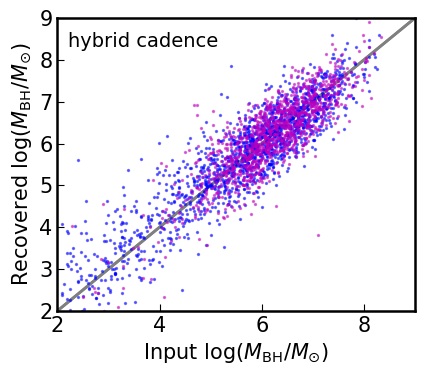

In [74]:
band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

cadence = 0

for k, (key, s) in enumerate(samples.items()):

    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    for j in range(1): ## Just use the first bootstrap
        
        for i, seed in enumerate(seed_keys):

            ndraw_dim = int(np.max(s['ndraws']))

            mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > cadence
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+5)
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
                                    
            tau_rest = s[f'tau_{seed}'][j,:ndraw_dim]/(1 + s[f'z_draw'][j,:ndraw_dim])
            M_BH = 10**7.97*(tau_rest/100)**2.54

            ax.scatter(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag & mask_tau]),
                       np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag & mask_tau],
                       color=colors[i], s=2, zorder=1, alpha=0.5)
            
            pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
            #ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)
            ax.plot([0, 9], [0, 9], lw=2, color='gray', zorder=0)
            M_cadence = 10**7.97*(cadence/100)**2.54
            #ax.plot([0, 9], [np.log10(M_cadence), np.log10(M_cadence)], lw=2, color='gray', linestyle='dashed', zorder=0)
            
            rmse_val = rmse(np.log10(s[f'M_BH_draw_{seed}'].value[j,:ndraw_dim][mask_mass & mask_var & mask_sat & mask_mag]),
                            np.log10(M_BH)[mask_mass & mask_var & mask_sat & mask_mag])
        #ax.text(2.2, 8.3, f'{cadence} day cadence', color='black', fontsize=14)
        ax.text(2.2, 8.3, f'hybrid cadence', color='black', fontsize=14)


    #ax.set_xlim([m_sat[key], m_5[key]])
    ax.set_xlabel(r'Input $\log(M_{\rm{BH}} / M_{\odot})$')
    ax.set_ylabel(r'Recovered $\log(M_{\rm{BH}} / M_{\odot})$')
    ax.set_xlim(2, 9)
    ax.set_ylim(2, 9)
    fig.tight_layout()
    fig.savefig(f'var_{key}_3_25.pdf', dpi=300)
    

In [120]:
s.keys()

dict_keys(['zmax', 'zmin', 'M_star_draw', 'n_i_M', 'z_draw', 'M_BH_draw', 'M_BH_draw_dc', 'n_i_M_dc', 'M_BH_draw_popIII', 'n_i_M_popIII', 'lambda_draw', 'n_i_Edd', 'L_draw_dc', 'n_i_L_dc', 'L_draw_popIII', 'n_i_L_popIII', 'ndraws', 'L_SDSS_g_model', 'M_i_model', 'L_SDSS_g_dc', 'M_i_dc', 'L_SDSS_g_popIII', 'M_i_popIII', 'lc_t_obs', 'lc_SDSS_g_dc_idx', 'm_SDSS_g_dc', 'm_host_SDSS_g_dc', 'SFinf_SDSS_g_dc', 'tau_RF_SDSS_g_dc', 'L_host_SDSS_g_dc', 'lc_SDSS_g_dc_0', 'lc_SDSS_g_dc_1', 'lc_SDSS_g_dc_2', 'lc_SDSS_g_dc_3', 'lc_SDSS_g_dc_4', 'lc_SDSS_g_dc_5', 'lc_SDSS_g_dc_6', 'lc_SDSS_g_dc_7', 'lc_SDSS_g_dc_8', 'lc_SDSS_g_dc_9', 'lc_SDSS_g_dc_10', 'lc_SDSS_g_dc_11', 'lc_SDSS_g_dc_12', 'lc_SDSS_g_dc_13', 'lc_SDSS_g_dc_14', 'lc_SDSS_g_dc_15', 'lc_SDSS_g_popIII_idx', 'm_SDSS_g_popIII', 'm_host_SDSS_g_popIII', 'SFinf_SDSS_g_popIII', 'tau_RF_SDSS_g_popIII', 'L_host_SDSS_g_popIII', 'lc_SDSS_g_popIII_0', 'lc_SDSS_g_popIII_1', 'lc_SDSS_g_popIII_2', 'lc_SDSS_g_popIII_3', 'lc_SDSS_g_popIII_4', 'lc_SDSS_g_

des-sn


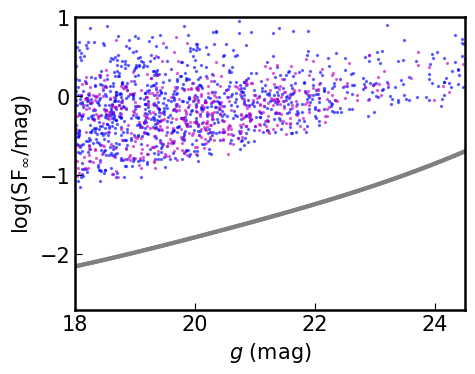

In [17]:
band_names = {'ptf':'R', 'lsst':'g', 'des-sn':'g'}

for k, (key, s) in enumerate(samples.items()):

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b','m']
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    for j in range(1): ## Just use the first bootstrap
        
        for i, seed in enumerate(seed_keys):

            ndraw_dim = int(np.max(s['ndraws']))

            mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
            #mask_tau = tau > 3
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]

            ax.scatter(s[f'm_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                       np.log10(s[f'SFinf_{band}_{seed}'][j,:ndraw_dim][mask_mass & mask_var & mask_sat]),
                       color=colors[i], s=2, zorder=1, alpha=0.5)
            # s[f'std_{seed}']
            
            pm_prec_key = pm_prec(m_eval, gamma=gamma[key], m_5=m_5[key])
            ax.plot(m_eval, np.log10(pm_prec_key), color='gray', lw=3)


    ax.set_xlim([m_sat[key], m_5[key]])
    ax.set_ylabel(r'$\log(\rm{{SF}}_{\infty} / {\rm{mag}})$')
    ax.set_xlabel(fr'${band_names[key]}$ (mag)')
    ax.set_ylim(-2.7, 1.0)
    fig.tight_layout()
    fig.savefig(f'SFinf_{key}.pdf', dpi=300)

ptf


No handles with labels found to put in legend.
No handles with labels found to put in legend.


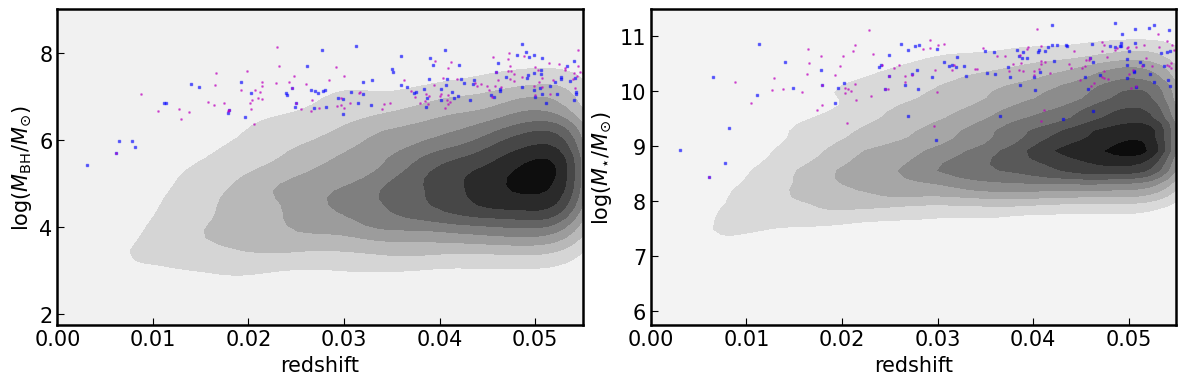

In [40]:
for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    colors = ['b', 'm'] # ['cyan'] 
    markers = ['s','o']
    print(key)
    
    fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

    for j in range(1): ## Just use the first bootstrap
        j=1

        for i, seed in enumerate(['dc','popIII']):

            ndraw_dim = int(np.max(s['ndraws']))

            mask_mass = s[f'M_BH_draw_{seed}'][j,:ndraw_dim] > 1e2*u.Msun
            mask_mass_all = s[f'M_BH_draw'][j,:ndraw_dim] > 1e2*u.Msun
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2

            x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
            y = np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_mag & mask_sat]

            if i == 0:
                # Peform the kernel density estimate
                xx, yy = np.mgrid[0:s['zmax']:60j, 1:10:60j]
                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])
                kernel = st.gaussian_kde(values)
                f = np.reshape(kernel(positions).T, xx.shape)

                # Contourf plot
                cfset = axs[0].contourf(xx, yy, f, levels=10, cmap='binary')

                #axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_sat],
                #               np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_sat],
                #               color='gray', s=1, zorder=5)

            axs[0].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                           np.log10(s[f'M_BH_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat],
                           color=colors[i], marker=markers[i], alpha=0.5, s=1)

            axs[0].set_ylim(1.75, 9)
            #axs[0].set_xlim(0, s['zmax'])
            axs[0].set_xlabel(r'redshift')
            axs[0].set_ylabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')

            x = s['z_draw'][j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
            y = np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)[mask_mass_all & mask_mag & mask_sat]

            if i == 0:
                # Peform the kernel density estimate
                xx, yy = np.mgrid[0:s['zmax']:60j, 5:12:60j]
                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])
                kernel = st.gaussian_kde(values)
                f = np.reshape(kernel(positions).T, xx.shape)

                cfset = axs[1].contourf(xx, yy, f, levels=10, cmap='binary')

            axs[1].scatter(s['z_draw'][j,:ndraw_dim][mask_mass & mask_var & mask_sat],
                           np.log10(s[f'M_star_draw'][j,:ndraw_dim].value)[mask_mass & mask_var & mask_sat],
                           color=colors[i], marker=markers[i], alpha=0.5, s=1)

            axs[1].set_ylim(5.75, 11.5)
            #axs[1].set_xlim(0, s['zmax'])
            #axs[1].set_yscale('log')
            axs[1].set_xlabel(r'redshift')
            axs[1].set_ylabel(r'$\log(M_{\star}/M_{\odot})$')

            ax.legend(fontsize=12)
            
            ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
            ax.tick_params(axis='both', which='major', length=6)
            ax.tick_params(axis='both', which='minor', length=3)
            ax.yaxis.set_ticks_position('both')
            ax.xaxis.set_ticks_position('both')

            fig.tight_layout()
            fig.savefig(f'massredshift_{key}.pdf', dpi=300)

In [ ]:
# try imposing mag limit on variable sources
# dwarf galaxies should not be this red

In [ ]:
labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
colors = ['b', 'm'] # ['cyan'] 
markers = ['s','o']
band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}
n_bin_min = 10

# Uncertainty in stellar mass measurements
logmass_sys_err = 0 #1.0 # dex, typically 0.3-0.4 dex
# are dominated by uncertainties in stellar evolution (Conroy et al. 2009).

data = [] # list of data to save

for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    seed_keys = list(pars[key]['seed_dict'].keys())
    print(key)

    label = labels[key]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.flatten()

    for i, seed in enumerate(seed_keys):

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        log_M_BH_all = np.log10(M_BH_all.value)

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)
        log_M_star_all += np.random.normal(0, logmass_sys_err, size=np.shape(s[f'M_star_draw']))

        bins = np.arange(5, 12.5, 0.5)
        M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)
        f_fap = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim] > 1e-2
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)

            #mask_mag_alt = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+1) 
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(m_star_bin, m_star_bin,
                                                                  statistic='count', bins=bins)
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(m_star_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            f_fap[j] = 0.05*bin_count_var/bin_count # FAP fraction
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            # Need to rescale total number of z<0.055 galaxies to 35,000 to match BGG20
            #axs[0].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        print(bin_centers)

        f[:,np.count_nonzero(f, axis=0) < n_bin_min] = np.nan
        axs[0].fill_between(bin_centers, np.nanpercentile(f, 16, axis=0), np.nanpercentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5)
        #axs[0].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        # There are some "simulation" noise here if eta is too large
        axs[0].scatter(bin_centers, np.nanmean(f, axis=0), lw=2, marker=markers[i], color=colors[i])
        axs[0].set_ylabel('recovered variable fraction')
        axs[0].set_xlabel(r'$\log(M_{\rm{\star}}/M_{\odot})$')
        #axs[1].set_xlim([6, 11])
        axs[0].text(0.04, 0.92, label, fontsize=12, transform=axs[0].transAxes)
        
        axs[0].set_xlim([np.min(bin_centers), np.max(bin_centers)])

        if key == 'ptf':
            from astropy.io import ascii
            dat = ascii.read('bgg20.txt')
            n = np.array([151, 519, 1313, 3237, 7467, 14052, 16367, 3188, 692, 155])[:-1]
            bgg_m = dat['col1'].data[:-1]
            bgg_f = dat['col2'].data[:-1]
            axs[0].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='r', capsize=3)
            
        # Power-law
        x = np.linspace(7, 9)
        y = (x-8)**0.5
        axs[0].plot(x, 1e-2*10**y, color='gray', lw=1, linestyle='dotted', zorder=-100)
            
        data.append(np.mean(f, axis=0))
        data.append(np.percentile(f, 16, axis=0))
        data.append(np.percentile(f, 84, axis=0))

        mag = s[f'm_{band}_{seed}']

        bins = np.arange(14, m_5[key], 0.5)
        M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)
        f_fap = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim] > 1e-2
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)
            
            mag_bin = mag[j,:ndraw_dim][mask_mag & mask_sat]
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(mag_bin, m_star_bin,
                                                                  statistic='count', bins=bins)
            mag_bin = mag[j,:ndraw_dim][mask_mass & mask_var & mask_sat]
            m_star_bin = log_M_star_all[j,:ndraw_dim][mask_mass & mask_var & mask_sat]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(mag_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            f_fap[j] = 0.05*bin_count_var/bin_count # FAP fraction
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            #axs[1].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        print(bin_centers)

        f[:,np.count_nonzero(f, axis=0) < n_bin_min] = np.nan
        axs[1].fill_between(bin_centers, np.nanpercentile(f, 16, axis=0), np.nanpercentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5)
        #axs[1].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        # There are some "simulation" noise here if eta is too large
        axs[1].scatter(bin_centers, np.nanmean(f, axis=0), lw=2, marker=markers[i], color=colors[i])
        axs[1].set_ylabel('recovered variable fraction')
        axs[1].set_xlabel(band_names[key])
        #axs[1].set_xlim([6, 11])
        axs[1].text(0.04, 0.92, label, fontsize=12, transform=axs[1].transAxes)

        if key == 'ptf':
            from astropy.io import ascii
            dat = ascii.read('bgg20_2.txt')
            n = np.array([409, 2520, 9881, 20261, 11523, 2159, 259])[:-1]
            bgg_m = dat['col1'].data[:-1]
            bgg_f = dat['col2'].data[:-1]
            axs[1].errorbar(bgg_m, bgg_f, st.binom.std(n, bgg_f)/n, marker='o', color='r', capsize=3)
            
        axs[1].set_xlim([m_sat[key], np.max(bin_centers)+0.5])
        
        data.append(np.mean(f, axis=0))
        data.append(np.percentile(f, 16, axis=0))
        data.append(np.percentile(f, 84, axis=0))

    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    
    axs[0].set_ylim([1e-5, 1e-1])
    axs[1].set_ylim([1e-5, 1e-1])
    
    for ax in axs:
        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')

    fig.tight_layout()
    fig.savefig(f'varfrac_{key}.pdf', dpi=300)
    np.save(f'varfrac_{key}.npy', data)

ptf


The smaller variable fraction for fainter sources could be because of under-estimated error bars in the real light curves from sextractor. These tend to over-estimate the number of massive galaxies, which tend to be brighter. Or it's an assumption in our model.

In [36]:
m_5['ptf']

20.5

des-sn
dc
46226.4375 29769.4375 29591.362500000003
1444.0625 727.0625 622.5374999999999
popIII


/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


4796.875 2306.075 2381.9249999999993
739.9375 248.33750000000003 229.26250000000005


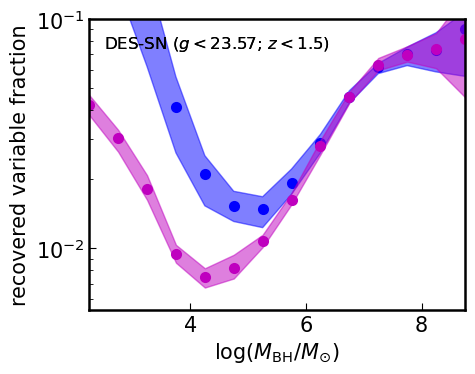

In [40]:
labels = {'ptf':fr'PTF ($R < {m_5["ptf"]}$; $z < {zmaxes["ptf"]}$)',
          'lsst':fr'LSST ($g < {m_5["lsst"]}$; $z < {zmaxes["lsst"]}$)',
          'des-sn':fr'DES-SN ($g < {m_5["des-sn"]}$; $z < {zmaxes["des-sn"]}$)'}
colors = ['b', 'm'] # ['cyan'] 
band_names = {'ptf':r'$R$ (mag)', 'lsst':r'$g$ (mag)', 'des-sn':r'$g$ (mag)'}


for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    print(key)

    label = labels[key]

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    for i, seed in enumerate(['dc','popIII']):
        
        print(seed)
        
        count_imbh = np.zeros(nbootstrap)
        count_mbh = np.zeros(nbootstrap)

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        log_M_BH_all = np.log10(M_BH_all.value)

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        bins = np.arange(2, 9.5, 0.5)
        M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)
        f_fap = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))

            mask_SF = s[f'SFinf_{band}_{seed}'][j,:ndraw_dim] > 1e-2
            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 1e2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 1e2*u.Msun)
            
            
            mask_imbh = (M_BH[j,:ndraw_dim] < 1e4*u.Msun)
            mass_mbh = (M_BH[j,:ndraw_dim] > 1e4*u.Msun) & (M_BH[j,:ndraw_dim] < 1e6*u.Msun)
            count_imbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mask_imbh)
            count_mbh[j] = np.count_nonzero(mask_mass & mask_var & mask_sat & mass_mbh)

            #mask_mag_alt = s[f'm_{band}_{seed}'][j,:ndraw_dim] < (m_5[key]+1) 
            m_bh_bin = log_M_BH_all[j,:ndraw_dim][mask_mass_all & mask_mag & mask_sat]
            bin_count, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                                  statistic='count', bins=bins)
            m_bh_bin = log_M_BH[j,:ndraw_dim][mask_mass & mask_var & mask_sat]
            bin_count_var, bin_edges, binnumber = st.binned_statistic(m_bh_bin, m_star_bin,
                                                                      statistic='count', bins=bins)
            f[j] = bin_count_var/bin_count
            f_fap[j] = 0.05*bin_count_var/bin_count # FAP fraction
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
            # Need to rescale total number of z<0.055 galaxies to 35,000 to match BGG20
            #axs[0].plot(bin_centers, f[j], color=colors[i], alpha=0.5)

        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        ax.fill_between(bin_centers, np.percentile(f, 16, axis=0), np.percentile(f, 84, axis=0),
                            color=colors[i], alpha=0.5)
        #axs[0].plot(bin_centers, np.mean(f_fap, axis=0), color=colors[i], linestyle='dashed', lw=3)
        # There are some "simulation" noise here if eta is too large
        ax.scatter(bin_centers, np.mean(f, axis=0), lw=2, color=colors[i])
        ax.set_ylabel('recovered variable fraction')
        ax.set_xlabel(r'$\log(M_{\rm{BH}}/M_{\odot})$')
        #axs[1].set_xlim([6, 11])
        ax.text(0.04, 0.90, label, fontsize=12, transform=ax.transAxes)

        mean_imbh = np.mean(count_imbh, axis=0)
        mean_mbh = np.mean(count_mbh, axis=0)
        print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
        print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

    ax.set_yscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim([None, 1e-1])
    ax.set_xlim([np.min(bin_centers), np.max(bin_centers)])

    fig.tight_layout()
    fig.savefig(f'varfrac_bh_{key}.pdf', dpi=300)

In [ ]:
mean_imbh = np.mean(count_imbh, axis=0)
mean_mbh = np.mean(count_mbh, axis=0)

print(mean_imbh, mean_imbh-np.percentile(count_imbh, 16, axis=0), np.percentile(count_imbh, 84, axis=0)-mean_imbh)
print(mean_mbh, mean_mbh-np.percentile(count_mbh, 16, axis=0), np.percentile(count_mbh, 84, axis=0)-mean_mbh)

In [ ]:
colors = ['b', 'm']
markers = ['s', 'o']
labels = {'ptf':r'PTF ($R < 20.5$; $z < 0.055$)', 'lsst':r'LSST ($g < 25.0$; $z < 0.055$)'}


for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    print(key)

    label = labels[key]

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    #axs = axs.flatten()

    for i, seed in enumerate(['dc','popIII']):

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        
        M_star_ = pars[key]['M_star_'].value
        M_star = pars[key]['M_star'].value

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        #for j in range(nbootstrap):
        ndraw = int(s['ndraws'][j])
        ndraw_dim = int(np.max(s['ndraws']))
        print(ndraw)

        mask_var = s[f'sigma_var_{seed}'][:,:ndraw_dim] > 2
        mask_tau = s[f'tau_RF_{band}_{seed}'][:,:ndraw_dim] > 5
        mask_mag = s[f'm_{band}_{seed}'][:,:ndraw_dim] < m_5[key]
        mask_sat = s[f'm_{band}_{seed}'][:,:ndraw_dim] > m_sat[key]
        mask_mass = (M_BH[:,:ndraw_dim] > 10**2*u.Msun)
        mask_mass_all = (M_BH_all[:,:ndraw_dim] > 0*u.Msun)

        # Non-var
        if i == 0:
            x = M_star_all[:,:ndraw_dim][mask_mag & mask_sat & mask_mass_all]
            y = M_BH[:,:ndraw_dim][mask_mag & mask_sat & mask_mass_all]

            # Plot
            bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
            bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
            bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

            ax.scatter(M_star, bin_med, lw=3, color='k')
            ax.fill_between(M_star, bin_hi, bin_lo, color='k', alpha=0.5)
        
        # Var
        x = M_star_all[:,:ndraw_dim][mask_var & mask_sat & mask_mass]
        y = M_BH[:,:ndraw_dim][mask_var & mask_sat & mask_mass]
        
        bin_med, _, _ = st.binned_statistic(x.flatten(), y.flatten(), np.nanmedian, bins=M_star_)
        bin_hi, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 84), bins=M_star_)
        bin_lo, _, _ = st.binned_statistic(x.flatten(), y.flatten(), lambda x: np.nanpercentile(x, 16), bins=M_star_)

        ax.scatter(M_star, bin_med, lw=3, color=colors[i], marker=markers[i])
        ax.fill_between(M_star, bin_hi, bin_lo, color=colors[i], alpha=0.5)
        
        ax.text(0.04, 0.90, labels[key], fontsize=12, transform=ax.transAxes)
        
        ax.set_xlabel(r'$M_{\rm{\star}}\ (M_{\odot})$', fontsize=18)
        ax.set_ylabel(r'$M_{\rm{BH}}\ (M_{\odot})$', fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([1e6, 1e11])
        ax.set_ylim([1e2, 1e8])
        
        ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', which='major', pad=7)

    fig.tight_layout()
    fig.savefig(f'massbias_{key}.pdf', dpi=300)

In [ ]:
for k, (key, s) in enumerate(samples.items()):

    s = samples[key]
    nbootstrap = pars[key]['nbootstrap']
    band = bands[key]
    print(key)

    label = labels[key]

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    fig2, axs2 = plt.subplots(1, 1, figsize=(6, 4))
    #axs = axs.flatten()

    for i, seed in enumerate(['dc','popIII']):

        M_BH = s[f'M_BH_draw_{seed}']
        M_BH_all = s[f'M_BH_draw']
        log_M_BH = np.log10(M_BH.value)
        log_M_BH = np.log10(M_BH.value)
        
        SF = s[f'SFinf_{band}_{seed}']

        M_star_all = s[f'M_star_draw']
        log_M_star_all = np.log10(M_star_all.value)

        bins = np.arange(5, 12.5, 0.5)
        M_star = np.log10(s[f'M_star_draw'].value)

        f = np.full([nbootstrap, len(bins)-1], np.nan)

        for j in range(nbootstrap):
            ndraw = int(s['ndraws'][j])
            ndraw_dim = int(np.max(s['ndraws']))
            print(ndraw)

            mask_var = s[f'sigma_var_{seed}'][j,:ndraw_dim] > 2
            mask_tau = s[f'tau_RF_{band}_{seed}'][j,:ndraw_dim] > 5
            mask_mag = s[f'm_{band}_{seed}'][j,:ndraw_dim] < m_5[key]
            mask_sat = s[f'm_{band}_{seed}'][j,:ndraw_dim] > m_sat[key]
            mask_mass = (M_BH[j,:ndraw_dim] > 10**2*u.Msun)
            mask_mass_all = (M_BH_all[j,:ndraw_dim] > 10**2*u.Msun)
            
            axs.scatter(np.log10(s[f'lambda_draw'])[j,:ndraw_dim][mask_var & mask_sat & mask_mass],
                           np.log10(SF[j,:ndraw_dim][mask_var & mask_sat & mask_mass]), s=.001, color='r', zorder=1)
            #axs.scatter(log_M_star_all[j,:ndraw_dim][mask_mass],
            #               np.log10(SF[j,:ndraw_dim][mask_mass]), s=.0001, color='gray', zorder=0)
            
            axs2.scatter(log_M_star_all[j,:ndraw_dim][mask_var & mask_sat & mask_mass],
                           np.log10(s[f'lambda_draw'][j,:ndraw_dim][mask_var & mask_sat & mask_mass]), s=.001, color='r', zorder=1)
            
            #axs.set_ylim([-2, 1])
            #axs2.set_ylim([-2, 1])

In [30]:
# Try fitting in log f_host and random in dex

### Visualize SED grid

In [31]:
band='SDSS_g'

NameError: name 'model' is not defined

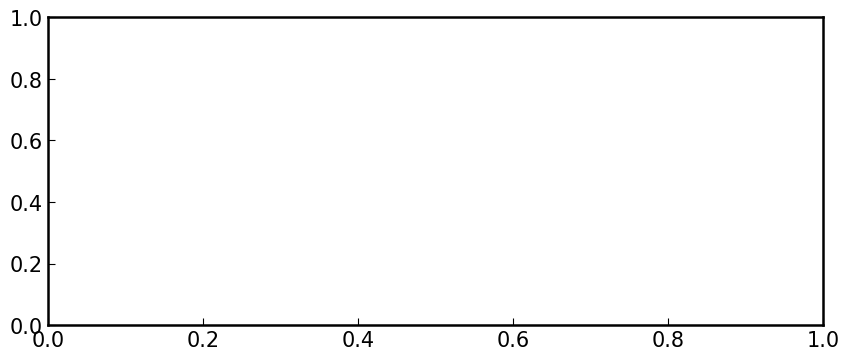

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][0,:,:].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')


ax.set_ylabel(r'$\lambda_{\rm{Edd}}$')
ax.set_xlabel('redshift')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5*2, 4))
from mpl_toolkits.axes_grid1 import make_axes_locatable

im = ax.imshow(np.log10(model.samples[f'L_{band}_model'][:,:,0].value)) # m, lambda, z
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(L_{g}/{\rm{erg}\ \rm{s}}^{1})$')

ax.set_ylabel(r'$M_{\rm{BH}}$')
ax.set_xlabel(r'$\lambda_{\rm{Edd}}$')

### Example SEDs

In [37]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

0.00701593806109562
optxagnf ['mass', 'dist', 'logLoLEdd', 'astar', 'rcor', 'logrout', 'kT_e', 'tau', 'Gamma', 'fpl', 'Redshift', 'norm']
39.56530053262444 39.10037054511756
41.56530053530371 41.10037054511756
43.56530053831617 43.10037054511756
45.5653005362672 45.10037054511756
diskir ['kT_disk', 'Gamma', 'kT_e', 'LcovrLd', 'fin', 'rirr', 'fout', 'logrout', 'norm']
0.10000036132738777


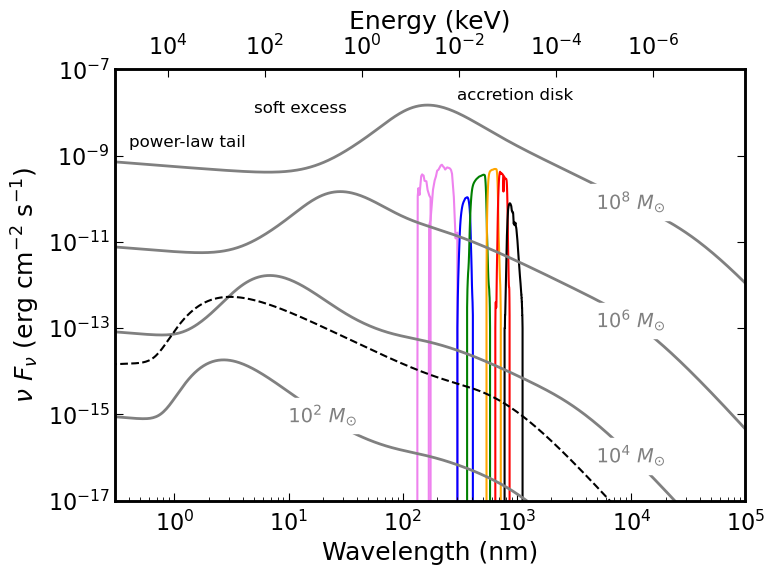

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")

# Print parameter names
ncomp = len(model_sed.componentNames)
for icomp in model_sed.componentNames:
    print(icomp, eval(f'model_sed.{icomp}.parameterNames'))

for i, M_BH_i in enumerate(bh_masses):
    
    pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = nuf_nu/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    ax.loglog(wav.value, nuf_nu.value, color='gray', lw=2, label=s)
    ax_top.loglog(energies.value[:-1], sed, alpha=0, lw=2)
    
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)



# Irradiated-disk model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node163.html)
# Parameters
#z = z_at_value(cosmo.comoving_distance, 95*u.Mpc)
#d_L = cosmo.luminosity_distance(z)

pars = {'kT_disk':0.17,'Gamma':2.1,'kT_e':0.07,'Lc/Ld':0.07,'fin':0.0,
        'rirr':1.0001,'fout':0.0013,'logrout': 3.7, 'norm':50}
#M_BH_HLX1 = 1e2*u.Msun

model_sed_HLX1 = xspec.Model("diskir")
#pars['bh_mass'] = M_BH_HLX1.to(u.Msun).value

# Print parameter names
ncomp = len(model_sed_HLX1.componentNames)
for icomp in model_sed_HLX1.componentNames:
    print(icomp, eval(f'model_sed_HLX1.{icomp}.parameterNames'))

model_sed_HLX1.setPars(list(pars.values()))
energies = model_sed_HLX1.energies(0)[::-1]*u.keV # Why N-1?
# RF -> Obs. frame
wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))

# E N_E dlogE to nu f_nu
dlogE = np.diff(np.log10(energies[::-1].value))
sed = model_sed_HLX1.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))

nuf_nu = nuf_nu*(30/95)**-2*(0.1/1.945) # Rescale to 30 Mpc and L/LEDD = 0.1
f_lambda = nuf_nu/wav
L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
L_bol = np.sum(L_lambda*dwav).value
L_Edd = 1.26e38 * 1e4
print(L_bol/L_Edd)

ax.loglog(wav.value, nuf_nu.value, color='k', lw=1.5, linestyle='dashed', zorder=10)



# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bands = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bands):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 1e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)

lines = ax.get_lines()
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,1e4,1e4,1e4]*len(lines))

for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Example light curves

0.08095089972077206 0.5248561335684977


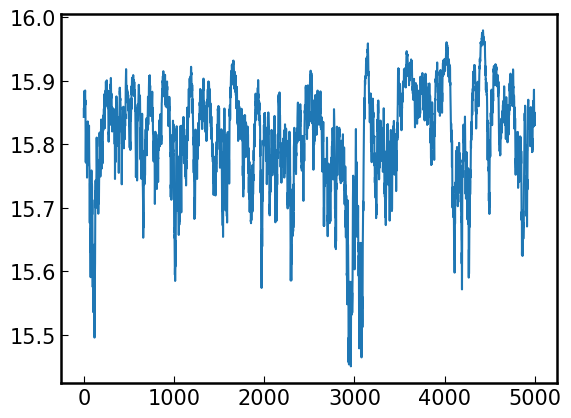

In [45]:
from model import simulate_drw
# Test host diulation
t_rest = np.arange(0, 5000, 1)
# The variable part is measured from quasars
m_var = simulate_drw(np.array([t_rest]).T, np.array([50]), np.array([0]), np.array([18]), np.array([0.5]))
# Now add a host galaxy
m = -2.5*np.log10(10**(-0.4*16) + 10**(-0.4*m_var))
# Now what is the new SF_inft?
print(np.std(m), np.std(m_var))

plt.plot(t_rest, m)

In [46]:
dm = 0.5
f1 = 10**(-0.4*18)
df = f1*np.log(10)/2.5*dm

f2 = 10**(-0.4*16)

dm_new = 2.5/np.log(10)*df/(f1+f2)

print(dm_new)

0.06840344430160501


In [47]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

tau_drw_Macleod = 10**dat['col8']*u.day
z = dat['col4']

edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge==0) & (Plike-Pnoise>2) & (Plike-Pinf>0.05) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
t = tau_drw_Macleod.to(u.year).value
SF_inf_Macleod = 10**(dat['col9']*(t**0.5))[mask] # log sigma

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

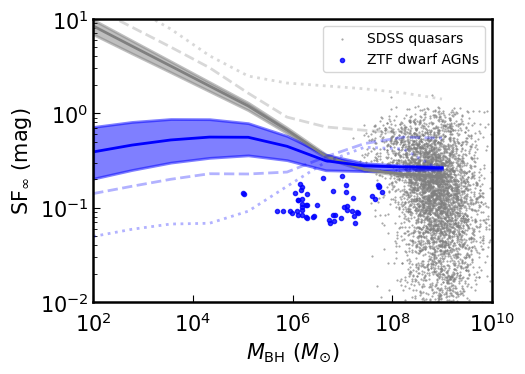

In [56]:
from model import get_AGN_flux, draw_SFinf

# Parameters
pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux)

size = 200
M_BH = np.logspace(2, 9, 10)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001]

z_ex = 0.007 # ~30 Mpc
f_host = 0.2 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.8 #0.4 # 0.2 - 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}

def g_minus_r_model(M_stellar):
    x = np.log10(M_stellar) - 10
    return 0.03177466*x**2 + 0.25283705*x + 0.72109552 + np.random.normal(0, 0.3, size=len(M_stellar))
        

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value, intercept=0.5)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)

# Data
ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, color='gray', alpha=0.8, label='SDSS quasars', zorder=-10)
ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

fig.tight_layout()
fig.savefig('SFinf.pdf', dpi=300)

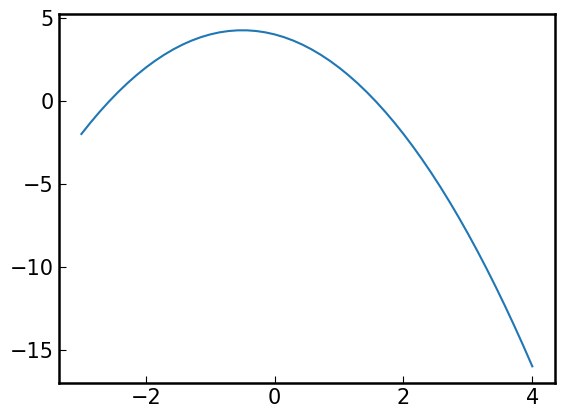

In [69]:
m = np.linspace(4, 11)
x = -(m - 8)
y = 5 - (x**2 + x + 1)
plt.plot(x, y)

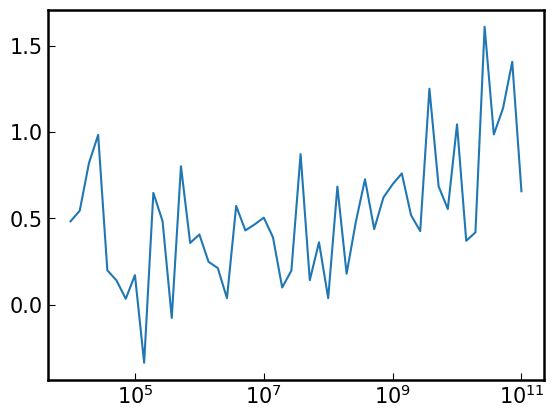

In [55]:
x = np.logspace(4, 11)
plt.semilogx(x, g_minus_r_model(x))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen
M_i_AGN = M_i_AGN + 0.5964 # assuming an alpha_nu =-0.5 contiuum spectrum

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)
fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

In [ ]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.5,  g_minus_i=0.8, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau2(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_i - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return simulate_drw2(t_rest, tau, z, m_band_AGN, SFinf)

In [ ]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

nex = len(bh_masses)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)

M_BH = [1e2, 1e4, 1e6, 1e8]*u.Msun

for i, M_BH_i in enumerate(M_BH):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BH) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
fig.savefig('lc_examples.pdf', dpi=300)